# Load data

In [ ]:
import pandas as pd
import os
import zipfile  # tambahkan ini

# ————— Langkah 1: Persiapan & Pemahaman Data —————
data_dir    = '/content/forest-cover-type-prediction.zip'    # ubah sesuai path ZIP-mu

# 1. Load data dari dalam ZIP
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    # Extract dan baca train.csv
    with zip_ref.open('train.csv') as f:
        train_df = pd.read_csv(f)
    # Extract dan baca test.csv
    with zip_ref.open('test.csv') as f:
        test_df  = pd.read_csv(f)

# 2. Intip struktur & isi
print("=== TRAIN — head ===")
print(train_df.head(), "\n")

print("=== TRAIN — info ===")
train_df.info()
print()

print("=== TRAIN — describe ===")
print(train_df.describe(), "\n")

# 3. Cek missing values
print("=== TRAIN — missing values per column ===")
print(train_df.isnull().sum().sort_values(ascending=False).head(), "\n")

# 4. Cek duplikasi ID
dupes = train_df['Id'].duplicated().sum()
print(f"=== TRAIN — duplicate Ids: {dupes} ===\n")

# (Opsional) Inspeksi TEST
print("=== TEST — head ===")
print(test_df.head(), "\n")

print("=== TEST — info ===")
test_df.info()

=== TRAIN — head ===
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1    

# Analisis korelasi raw features

Top 10 korelasi fitur raw dengan target:
Cover_Type          1.000000
Soil_Type38         0.257810
Soil_Type39         0.240384
Wilderness_Area1    0.230117
Soil_Type29         0.218564
Soil_Type40         0.205851
Soil_Type22         0.195993
Soil_Type23         0.158762
Soil_Type32         0.132312
Soil_Type12         0.129985
Name: Cover_Type, dtype: float64


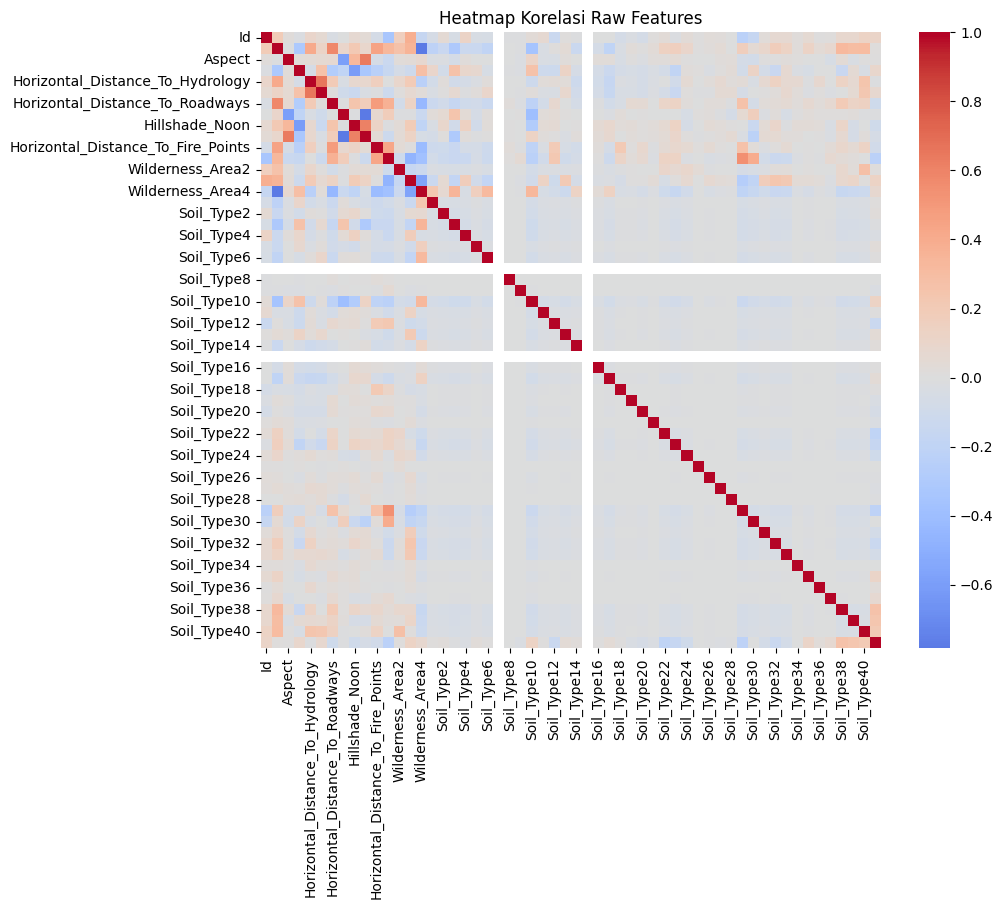

Fitur: Soil_Type38 | R²: 0.066


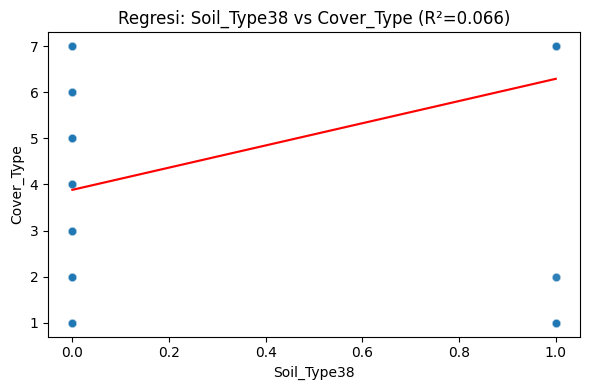

Fitur: Soil_Type39 | R²: 0.058


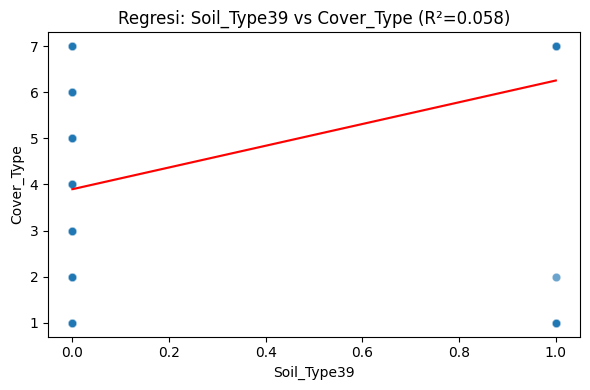

Fitur: Wilderness_Area1 | R²: 0.053


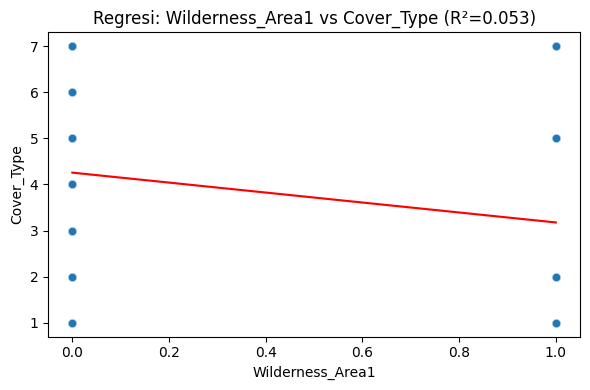

In [ ]:
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 1. Load data (raw) dari ZIP
zip_path = '/content/forest-cover-type-prediction.zip'
with zipfile.ZipFile(zip_path, 'r') as zf:
    df = pd.read_csv(zf.open('train.csv'))

# 2a. Analisis Korelasi fitur‑fitur raw dengan target
corr = df.corr()['Cover_Type'].abs().sort_values(ascending=False)
print("Top 10 korelasi fitur raw dengan target:")
print(corr.head(10))

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Heatmap Korelasi Raw Features")
plt.show()

# 2b. Regresi Sederhana untuk 3 Fitur Teratas
top_feats = corr.index.drop('Cover_Type')[0:3]  # ambil tiga fitur paling tinggi korelasinya

for feat in top_feats:
    X_feat = df[[feat]].values            # shape (n, 1)
    y_target = df['Cover_Type'].values    # label numeric 1–7

    # Fit linear regression dan hitung R^2
    lr = LinearRegression().fit(X_feat, y_target)
    y_pred = lr.predict(X_feat)
    r2 = r2_score(y_target, y_pred)
    print(f'Fitur: {feat} | R²: {r2:.3f}')

    # Plot scatter dan regression line
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=feat, y='Cover_Type', data=df, alpha=0.3)
    sns.lineplot(x=df[feat], y=y_pred, color='red')
    plt.title(f'Regresi: {feat} vs Cover_Type (R²={r2:.3f})')
    plt.xlabel(feat)
    plt.ylabel('Cover_Type')
    plt.tight_layout()
    plt.show()

# Pemisahan fitur (X) dan target (y)

In [ ]:
# 1. Setelah load dan FE:
zip_path = '/content/forest-cover-type-prediction.zip'
with zipfile.ZipFile(zip_path, 'r') as zf:
    df = pd.read_csv(zf.open('train.csv'))# atau dari ZIP
df_fe = featurize(df)                 # hasil Feature Engineering

# 2. Pisahkan X dan y:
X = df_fe.drop(columns=['Id', 'Cover_Type'])
y = df_fe['Cover_Type'] - 1           # ubah label jadi 0–6

# 3. Cek:
print("Shape X:", X.shape)
print("Unique y:", sorted(y.unique()))

Shape X: (15120, 17)
Unique y: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]


# Feature engineering

In [ ]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split

# 1. Load data (sesuaikan path)
zip_path = '/content/forest-cover-type-prediction.zip'
with zipfile.ZipFile(zip_path, 'r') as zf:
    df = pd.read_csv(zf.open('train.csv'))

# 2. Feature Engineering (contoh fungsi featurize)
def featurize(df):
    df = df.copy()
    # Euclidean distance ke hydrology
    df['Hydro_Dist'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology']**2 +
        df['Vertical_Distance_To_Hydrology']**2
    )
    # Hillshade stats
    shade = df[['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']]
    df['Hillshade_Mean']  = shade.mean(axis=1)
    df['Hillshade_Range'] = shade.max(axis=1) - shade.min(axis=1)
    # Northness & Eastness
    rad_asp = np.deg2rad(df['Aspect'])
    rad_slp = np.deg2rad(df['Slope'])
    df['Northness'] = np.cos(rad_asp) * np.sin(rad_slp)
    df['Eastness']  = np.sin(rad_asp) * np.sin(rad_slp)
    # Encode Soil_Type & Wilderness_Area ke kode tunggal
    soil_cols = [c for c in df if c.startswith('Soil_Type')]
    wa_cols   = [c for c in df if c.startswith('Wilderness_Area')]
    df['Soil_Code'] = df[soil_cols].values.argmax(axis=1)
    df['WA_Code']   = df[wa_cols].values.argmax(axis=1)
    df.drop(columns=soil_cols+wa_cols, inplace=True)
    return df

# 4. Train/Validation Split (hold‑out)
X_train, X_val, y_train, y_val = train_test_split(
    X,            # semua fitur setelah FE
    y,            # label (0–6)
    test_size=0.2,
    stratify=y,   # jaga distribusi kelas
    random_state=42
)

# Fitur baru berdasarkan domain
for d in [X_train, X_val]:
    d['Hydro_Dist'] = np.sqrt(
        d['Horizontal_Distance_To_Hydrology']**2 +
        d['Vertical_Distance_To_Hydrology']**2
    )
    d['Hillshade_Mean'] = d[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    d['Hillshade_Range'] = d[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - \
                           d[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)

    rad_aspect = np.deg2rad(d['Aspect'])
    rad_slope = np.deg2rad(d['Slope'])
    d['Northness'] = np.cos(rad_aspect) * np.sin(rad_slope)
    d['Eastness']  = np.sin(rad_aspect) * np.sin(rad_slope)


print(f"X_train shape: {X_train.shape}")
print(f"X_val   shape: {X_val.shape}")
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_val   distribution:\n",   y_val.value_counts(normalize=True))

X_train shape: (12096, 17)
X_val   shape: (3024, 17)
y_train distribution:
 Cover_Type
4    0.142857
5    0.142857
0    0.142857
6    0.142857
2    0.142857
3    0.142857
1    0.142857
Name: proportion, dtype: float64
y_val   distribution:
 Cover_Type
3    0.142857
5    0.142857
4    0.142857
6    0.142857
1    0.142857
2    0.142857
0    0.142857
Name: proportion, dtype: float64


In [ ]:
import numpy as np

def advanced_feature_engineering(df):
    df = df.copy()

    # Euclidean distance to hydrology
    df['Hydro_Dist'] = np.sqrt(
        df['Horizontal_Distance_To_Hydrology']**2 +
        df['Vertical_Distance_To_Hydrology']**2
    )

    # Hillshade statistics
    df['Hillshade_Mean'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    df['Hillshade_Range'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - \
                            df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)

    # Aspect + Slope transforms
    rad_aspect = np.deg2rad(df['Aspect'])
    rad_slope = np.deg2rad(df['Slope'])
    df['Northness'] = np.cos(rad_aspect) * np.sin(rad_slope)
    df['Eastness']  = np.sin(rad_aspect) * np.sin(rad_slope)

    return df

In [ ]:
import zipfile
import pandas as pd

# Load test.csv dari ZIP (pastikan path-nya benar)
zip_path = '/content/forest-cover-type-prediction.zip'
with zipfile.ZipFile(zip_path, 'r') as zf:
    test_df = pd.read_csv(zf.open('test.csv'))

# Drop kolom ID dan lakukan feature engineering
X_test = advanced_feature_engineering(test_df.drop(columns=['Id']))

def advanced_feature_engineering(df):
    df = df.copy()
    df['Hydro_Dist'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + 1)
    df['Hydro_Road_Ratio'] = df['Horizontal_Distance_To_Hydrology'] / (df['Horizontal_Distance_To_Roadways'] + 1)
    df['Hydro_Fire_Diff'] = np.abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])

    rad_asp = np.deg2rad(df['Aspect'])
    rad_slope = np.deg2rad(df['Slope'])
    df['Northness'] = np.cos(rad_asp) * np.sin(rad_slope)
    df['Eastness']  = np.sin(rad_asp) * np.sin(rad_slope)

    df['Elev_Slope'] = df['Elevation'] * df['Slope']
    df['Elev_Aspect'] = df['Elevation'] * df['Aspect']

    df['Hillshade_Mean'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    df['Hillshade_Range'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - \
                            df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
    return df

# Terapkan ke data
X_train = advanced_feature_engineering(X_train)
X_val   = advanced_feature_engineering(X_val)
X_test  = advanced_feature_engineering(X_test)

# Split train/validation

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Feature Engineering (from cell 98)
def advanced_feature_engineering(df):
    # ... (Your existing feature engineering code) ...
    # Add the content of the function here
    df = df.copy()
    df['Hydro_Dist'] = np.sqrt(df['Horizontal_Distance_To_Hydrology']**2 + 1)
    df['Hydro_Road_Ratio'] = df['Horizontal_Distance_To_Hydrology'] / (df['Horizontal_Distance_To_Roadways'] + 1)
    df['Hydro_Fire_Diff'] = np.abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])

    rad_asp = np.deg2rad(df['Aspect'])
    rad_slope = np.deg2rad(df['Slope'])
    df['Northness'] = np.cos(rad_asp) * np.sin(rad_slope)
    df['Eastness']  = np.sin(rad_asp) * np.sin(rad_slope)

    df['Elev_Slope'] = df['Elevation'] * df['Slope']
    df['Elev_Aspect'] = df['Elevation'] * df['Aspect']

    df['Hillshade_Mean'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
    df['Hillshade_Range'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].max(axis=1) - \
                            df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].min(axis=1)
    return df

# 2. Apply feature engineering before scaling
X_train = advanced_feature_engineering(X_train)
X_val   = advanced_feature_engineering(X_val)

# 3. Define num_feats and scale
num_feats = [
    'Elevation', 'Slope', 'Hydro_Dist',
    'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points', 'Hillshade_Mean', 'Hillshade_Range',
    'Northness', 'Eastness', 'Elev_Slope', 'Elev_Aspect', 'Hydro_Road_Ratio', 'Hydro_Fire_Diff'
]

scaler = StandardScaler().fit(X_train[num_feats])
X_train[num_feats] = scaler.transform(X_train[num_feats])
X_val[num_feats]   = scaler.transform(X_val[num_feats])

# Scaling fitur numerik

In [ ]:
from sklearn.preprocessing import StandardScaler

num_feats = [
    'Elevation', 'Slope', 'Hydro_Dist',
    'Horizontal_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points', 'Hillshade_Mean', 'Hillshade_Range',
    'Northness', 'Eastness', 'Elev_Slope', 'Elev_Aspect', 'Hydro_Road_Ratio', 'Hydro_Fire_Diff'
]

scaler = StandardScaler().fit(X_train[num_feats])
X_train[num_feats] = scaler.transform(X_train[num_feats])
X_val[num_feats]   = scaler.transform(X_val[num_feats])

# Modeling baseline

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inisialisasi model default
baseline_model = XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    eval_metric='mlogloss',
    random_state=42
)

# Training
baseline_model.fit(X_train, y_train)

# Prediksi & evaluasi
y_val_pred = baseline_model.predict(X_val)

print("Baseline Accuracy (dengan FE):", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=[f"Class_{i+1}" for i in range(7)]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Baseline Accuracy (dengan FE): 0.8538359788359788

Classification Report:
              precision    recall  f1-score   support

     Class_1       0.78      0.76      0.77       432
     Class_2       0.77      0.64      0.70       432
     Class_3       0.83      0.79      0.81       432
     Class_4       0.96      0.98      0.97       432
     Class_5       0.87      0.95      0.91       432
     Class_6       0.82      0.88      0.85       432
     Class_7       0.94      0.98      0.96       432

    accuracy                           0.85      3024
   macro avg       0.85      0.85      0.85      3024
weighted avg       0.85      0.85      0.85      3024


Confusion Matrix:
[[327  73   1   0   5   1  25]
 [ 82 276  12   0  41  17   4]
 [  0   3 343  13  13  60   0]
 [  0   0   7 422   0   3   0]
 [  2   8   7   0 411   4   0]
 [  1   0  41   5   5 380   0]
 [  9   0   0   0   0   0 423]]


# Hyperparameter tuning

In [ ]:
# Step 1: Latih model ringan untuk ambil SHAP
temp_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    eval_metric='mlogloss',
    tree_method='hist',
    n_estimators=100,
    max_depth=4,
    use_label_encoder=False,
    random_state=42
)
temp_model.fit(X_train, y_train)

# Step 2: SHAP importance
import shap
explainer = shap.TreeExplainer(temp_model)
shap_values = explainer.shap_values(X_train)

# Calculate mean across classes (axis=1) before calculating importance
shap_importance = np.abs(shap_values).mean(axis=0).mean(axis=1)

shap_df = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# Step 3: Ambil top 30 fitur
top_feats = shap_df.head(30).index.tolist()
X_train_shap = X_train[top_feats]
X_val_shap   = X_val[top_feats]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:11:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time, datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SMOTE: Oversample kelas 0,1,2,5 (Class 1,2,3,6)
target_classes = [0, 1, 2, 5]
max_class_size = y_train.value_counts().max()
smote = SMOTE(
    sampling_strategy={cls: max_class_size for cls in target_classes},
    random_state=42
)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 2. Model dasar XGBoost
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=7,
    eval_metric='mlogloss',
    tree_method='hist',
    use_label_encoder=False,
    random_state=42
)

# 3. Hyperparameter space dengan learning_rate tinggi
param_dist = {
    'n_estimators':      [200, 400, 600],
    'learning_rate':     [0.07, 0.1, 0.15],
    'max_depth':         [6, 8, 10],
    'subsample':         [0.8, 0.9, 1.0],
    'colsample_bytree':  [0.8, 0.9, 1.0],
    'gamma':             [0, 0.1, 0.2],
    'reg_alpha':         [0, 0.1, 0.3],
    'reg_lambda':        [1, 2, 3],
    'min_child_weight':  [1, 3, 5]
}

# 4. Setup tuning
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=75,
    scoring='accuracy',
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 5. Tuning
print(" Mulai tuning...")
start = time.time()
rand_search.fit(X_train_sm, y_train_sm)
elapsed = str(datetime.timedelta(seconds=int(time.time() - start)))
print(f"\n Tuning selesai dalam {elapsed}")
print(" Best Params:", rand_search.best_params_)
print(f" Best CV Accuracy: {rand_search.best_score_:.4f}")


 Mulai tuning...
Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:07:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Tuning selesai dalam 0:55:49
 Best Params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.9}
 Best CV Accuracy: 0.8598


In [ ]:
import shap
import pandas as pd
import numpy as np

# Hitung SHAP, but use X_train_sel instead of X_train
explainer = shap.TreeExplainer(best_model.named_steps['clf'])  # ambil clf dari pipeline
shap_vals = explainer.shap_values(X_train_sel) # Use X_train_sel for consistency

# Rata-rata SHAP values across classes before calculating importance
shap_importance = np.abs(shap_vals).mean(axis=0).mean(axis=1) # Calculate mean across classes (axis=1)

shap_df = pd.Series(shap_importance, index=X_train_sel.columns).sort_values(ascending=False) # Use X_train_sel columns

# Ambil top 30 fitur terbaik
top_feats = shap_df.head(30).index.tolist()
X_train_sel = X_train_sel[top_feats] # Use X_train_sel for consistency
X_val_sel   = X_val_sel[top_feats] # Use X_val_sel for consistency

# Train Final

In [ ]:
import xgboost as xgb
from xgboost.callback import EarlyStopping

# 1. Buat DMatrix
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dval   = xgb.DMatrix(X_val_sel, label=y_val)

# 2. Ambil parameter terbaik dari hasil tuning
params = {
    'objective': 'multi:softprob',
    'num_class': 7,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'verbosity': 1,
    **{k.replace('clf__', ''): v for k, v in best_params.items()}
}

# 3. Training final dengan early stopping
final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    callbacks=[EarlyStopping(rounds=30)],
    verbose_eval=10
)

[0]	train-mlogloss:1.88677	val-mlogloss:1.89021


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:43:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-mlogloss:1.44721	val-mlogloss:1.48179
[20]	train-mlogloss:1.17799	val-mlogloss:1.23380
[30]	train-mlogloss:0.98663	val-mlogloss:1.05931
[40]	train-mlogloss:0.84424	val-mlogloss:0.93090
[50]	train-mlogloss:0.73509	val-mlogloss:0.83430
[60]	train-mlogloss:0.65012	val-mlogloss:0.75948
[70]	train-mlogloss:0.58245	val-mlogloss:0.70147
[80]	train-mlogloss:0.52928	val-mlogloss:0.65542
[90]	train-mlogloss:0.48493	val-mlogloss:0.61863
[100]	train-mlogloss:0.44777	val-mlogloss:0.58823
[110]	train-mlogloss:0.41672	val-mlogloss:0.56311
[120]	train-mlogloss:0.38930	val-mlogloss:0.54186
[130]	train-mlogloss:0.36748	val-mlogloss:0.52518
[140]	train-mlogloss:0.34853	val-mlogloss:0.51103
[150]	train-mlogloss:0.33223	val-mlogloss:0.49913
[160]	train-mlogloss:0.31718	val-mlogloss:0.48865
[170]	train-mlogloss:0.30383	val-mlogloss:0.47903
[180]	train-mlogloss:0.29161	val-mlogloss:0.47138
[190]	train-mlogloss:0.28063	val-mlogloss:0.46414
[200]	train-mlogloss:0.26990	val-mlogloss:0.45769
[210]	tra

In [ ]:
from xgboost import XGBClassifier

# 1. Inisialisasi model dengan best params dari RandomizedSearchCV
xgb_final = XGBClassifier(
    **rand_search.best_params_,
    objective='multi:softprob',
    num_class=7,
    eval_metric='mlogloss',
    tree_method='hist',
    random_state=42
)

# 2. Latih model langsung tanpa early stopping
xgb_final.fit(X_train, y_train)

# 3. (Opsional) Prediksi dan evaluasi
y_val_pred = xgb_final.predict(X_val)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Final Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=[f"Class_{i+1}" for i in range(7)]))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Final Validation Accuracy: 0.8621
Classification Report:
              precision    recall  f1-score   support

     Class_1       0.78      0.77      0.78       432
     Class_2       0.76      0.64      0.70       432
     Class_3       0.85      0.83      0.84       432
     Class_4       0.95      0.98      0.96       432
     Class_5       0.87      0.95      0.91       432
     Class_6       0.85      0.89      0.87       432
     Class_7       0.94      0.97      0.96       432

    accuracy                           0.86      3024
   macro avg       0.86      0.86      0.86      3024
weighted avg       0.86      0.86      0.86      3024

Confusion Matrix:
[[332  74   1   0   3   1  21]
 [ 80 278  13   0  39  17   5]
 [  0   2 357  16  12  45   0]
 [  0   0   6 423   0   3   0]
 [  1   9   8   0 410   4   0]
 [  0   1  34   6   5 386   0]
 [ 11   0   0   0   0   0 421]]


# Evaluasi


Final Validation Accuracy: 0.8621

Classification Report:
              precision    recall  f1-score   support

     Class_1       0.78      0.77      0.78       432
     Class_2       0.76      0.64      0.70       432
     Class_3       0.85      0.83      0.84       432
     Class_4       0.95      0.98      0.96       432
     Class_5       0.87      0.95      0.91       432
     Class_6       0.85      0.89      0.87       432
     Class_7       0.94      0.97      0.96       432

    accuracy                           0.86      3024
   macro avg       0.86      0.86      0.86      3024
weighted avg       0.86      0.86      0.86      3024



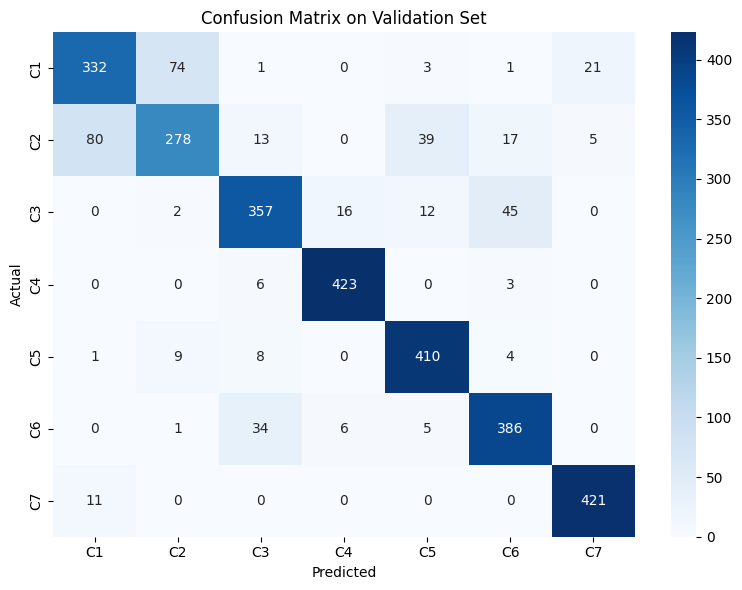

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prediksi
y_val_pred = xgb_final.predict(X_val)

# 2. Akurasi
acc = accuracy_score(y_val, y_val_pred)
print(f"\nFinal Validation Accuracy: {acc:.4f}")

# 3. Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=[f"Class_{i+1}" for i in range(7)]))

# 4. Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"C{i+1}" for i in range(7)],
            yticklabels=[f"C{i+1}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()